In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {device}')

# Set random seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)


Menggunakan device: cpu


In [2]:
# Path dataset
dataset_root = 'dataset'  # Path ke folder dataset utama (sekarang di notebook/dataset)
train_dir = 'dataset/train'
val_dir = 'dataset/val'

# Buat struktur folder jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Kelas yang akan digunakan
classes = ['hawar', 'sehat', 'karat']

# Buat folder untuk setiap kelas di train dan val
for split in ['train', 'val']:
    for cls in classes:
        os.makedirs(f'dataset/{split}/{cls}', exist_ok=True)

print("Struktur folder dataset sudah dibuat!")


Struktur folder dataset sudah dibuat!


In [3]:
# Fungsi untuk memisahkan dataset menjadi train dan validation
def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8):
    """
    Memisahkan dataset dari folder sumber ke train dan validation
    source_dir: folder utama yang berisi subfolder Hawar, Sehat, Karat
    """
    # Mapping nama folder
    class_mapping = {
        'Hawar': 'hawar',
        'Sehat': 'sehat',
        'Karat': 'karat'
    }
    
    for class_folder in os.listdir(source_dir):
        if class_folder in class_mapping:
            source_path = os.path.join(source_dir, class_folder)
            if os.path.isdir(source_path):
                # Ambil semua file gambar
                images = [f for f in os.listdir(source_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                # Shuffle
                np.random.shuffle(images)
                
                # Split
                split_idx = int(len(images) * split_ratio)
                train_images = images[:split_idx]
                val_images = images[split_idx:]
                
                # Copy ke folder train
                target_class = class_mapping[class_folder]
                for img in train_images:
                    src = os.path.join(source_path, img)
                    dst = os.path.join(train_dir, target_class, img)
                    shutil.copy2(src, dst)
                
                # Copy ke folder val
                for img in val_images:
                    src = os.path.join(source_path, img)
                    dst = os.path.join(val_dir, target_class, img)
                    shutil.copy2(src, dst)
                
                print(f'{class_folder}: {len(train_images)} train, {len(val_images)} val')

# Jalankan split dataset untuk memisahkan dataset menjadi train dan validation
split_dataset(dataset_root, train_dir, val_dir, split_ratio=0.8)
print("Dataset sudah siap digunakan!")


Hawar: 85 train, 22 val
Karat: 81 train, 21 val
Sehat: 80 train, 21 val
Dataset sudah siap digunakan!


In [4]:
# ImageNet normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformasi untuk training (dengan augmentasi yang lebih agresif untuk akurasi tinggi)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33))
])

# Transformasi untuk validation (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("Transformasi sudah didefinisikan!")


Transformasi sudah didefinisikan!


VISUALISASI PREPROCESSING - BEFORE & AFTER

✓ Gambar sample: 001.jpg
✓ Ukuran original: 2850x2850 pixels


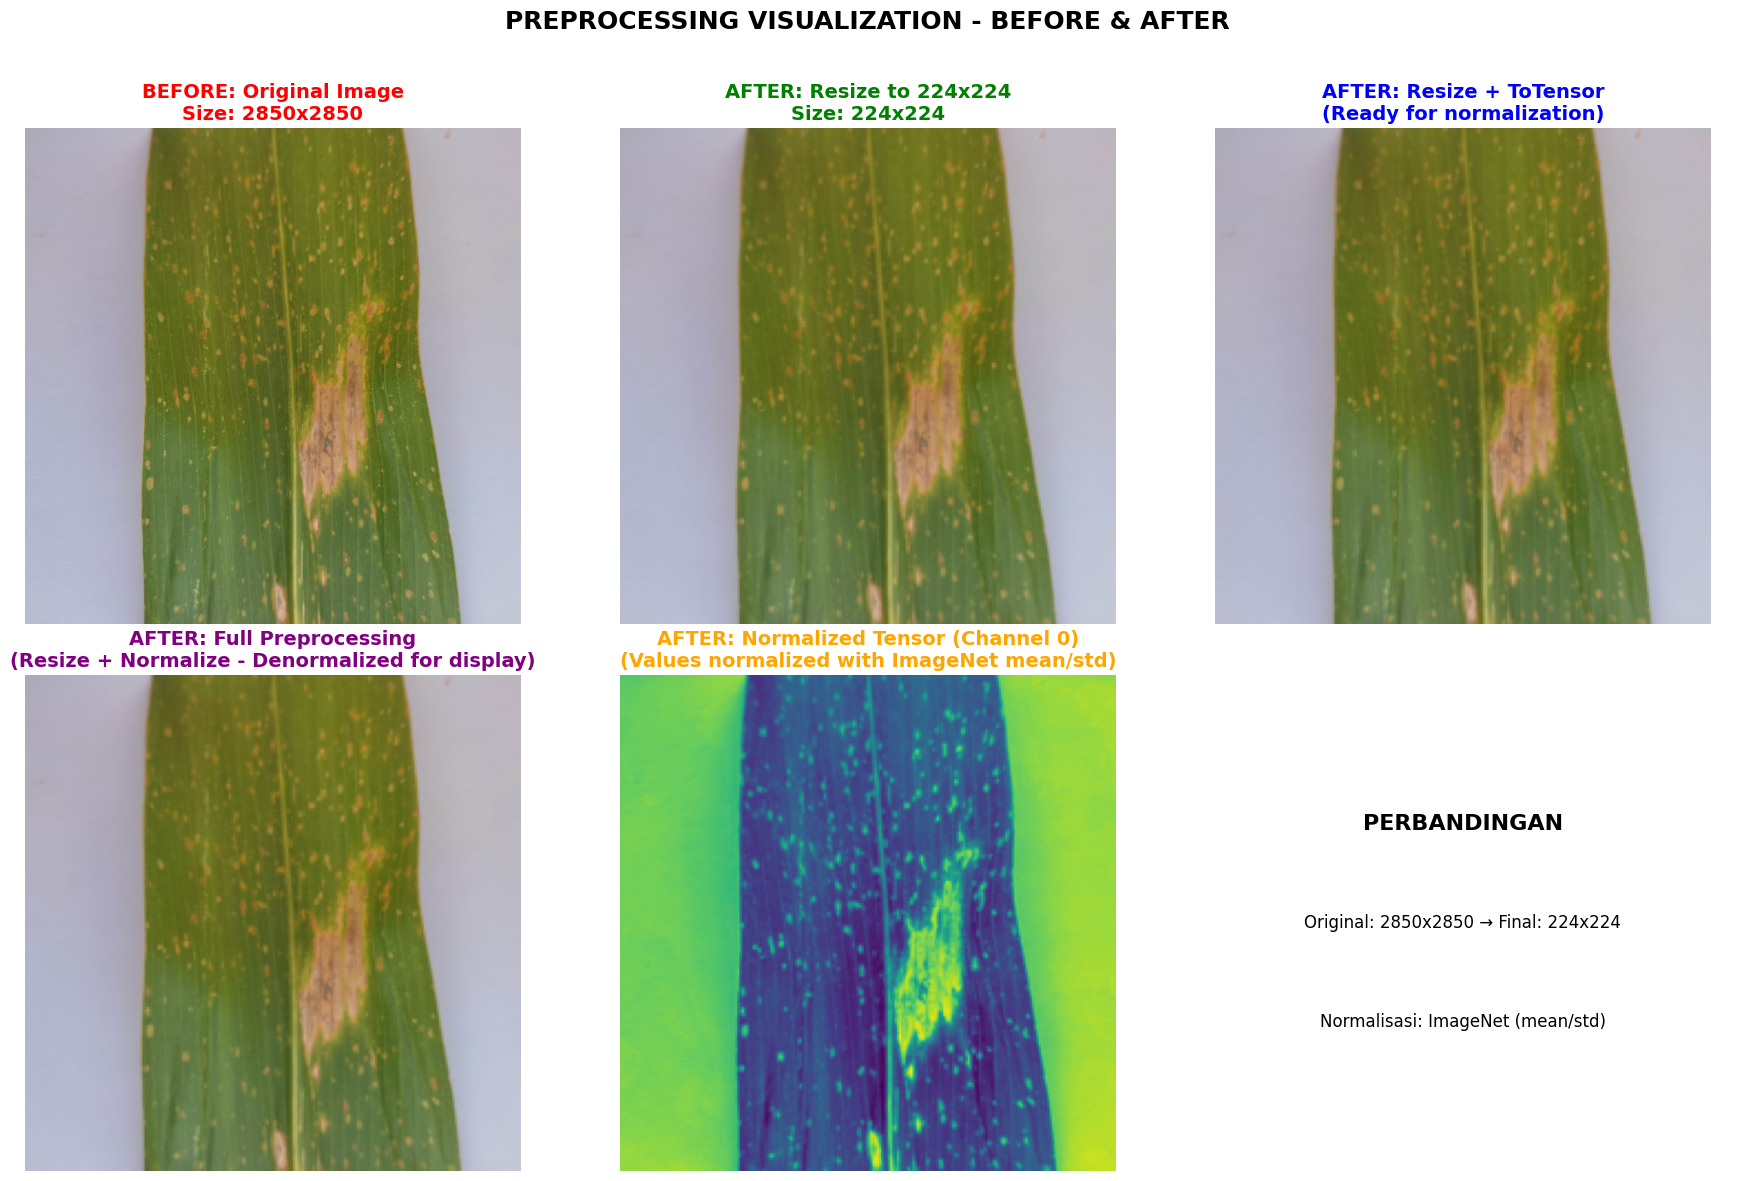


------------------------------------------------------------
RINGKASAN PREPROCESSING:
------------------------------------------------------------
1. BEFORE: Original Image
   - Size: 2850x2850 pixels
   - Format: RGB

2. AFTER: Resize
   - Size: 224x224 pixels
   - Method: Bilinear interpolation

3. AFTER: Normalization
   - Mean: [0.485, 0.456, 0.406]
   - Std: [0.229, 0.224, 0.225]
   - Range: [-2.5, 2.5] (approximately)

4. FINAL: Ready for Model
   - Shape: (3, 224, 224)
   - Type: torch.Tensor
   - Normalized: Yes
------------------------------------------------------------


In [5]:
# Visualisasi Preprocessing - Before & After
print("=" * 60)
print("VISUALISASI PREPROCESSING - BEFORE & AFTER")
print("=" * 60)

# Fungsi untuk denormalize tensor untuk visualisasi
def denormalize_tensor(tensor, mean, std):
    """Denormalize tensor untuk visualisasi"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

# Ambil satu gambar sample dari dataset
sample_img_path = None
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            sample_img_path = os.path.join(root, file)
            break
    if sample_img_path:
        break

if sample_img_path:
    # Load gambar original
    original_img = Image.open(sample_img_path).convert('RGB')
    original_size = original_img.size
    print(f"\n✓ Gambar sample: {os.path.basename(sample_img_path)}")
    print(f"✓ Ukuran original: {original_size[0]}x{original_size[1]} pixels")
    
    # 1. BEFORE: Gambar Original
    # 2. AFTER: Resize ke 224x224
    resize_transform = transforms.Resize((224, 224))
    resized_img = resize_transform(original_img)
    
    # 3. AFTER: Resize + ToTensor (untuk visualisasi)
    resize_tensor_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    resized_tensor = resize_tensor_transform(original_img)
    
    # 4. AFTER: Full preprocessing (Resize + Normalize)
    normalized_tensor = val_transform(original_img)
    
    # 5. AFTER: Full preprocessing dengan denormalize untuk visualisasi
    normalized_vis = denormalize_tensor(normalized_tensor, mean, std)
    
    # Visualisasi
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original dan Resize
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title(f'BEFORE: Original Image\nSize: {original_size[0]}x{original_size[1]}', 
                        fontsize=14, fontweight='bold', color='red')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(resized_img)
    axes[0, 1].set_title('AFTER: Resize to 224x224\nSize: 224x224', 
                         fontsize=14, fontweight='bold', color='green')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(resized_tensor.permute(1, 2, 0))
    axes[0, 2].set_title('AFTER: Resize + ToTensor\n(Ready for normalization)', 
                         fontsize=14, fontweight='bold', color='blue')
    axes[0, 2].axis('off')
    
    # Row 2: Normalized (raw tensor) dan Normalized (denormalized untuk visualisasi)
    axes[1, 0].imshow(normalized_vis.permute(1, 2, 0))
    axes[1, 0].set_title('AFTER: Full Preprocessing\n(Resize + Normalize - Denormalized for display)', 
                         fontsize=14, fontweight='bold', color='purple')
    axes[1, 0].axis('off')
    
    # Show normalized tensor values (as heatmap for one channel)
    axes[1, 1].imshow(normalized_tensor[0].numpy(), cmap='viridis')
    axes[1, 1].set_title('AFTER: Normalized Tensor (Channel 0)\n(Values normalized with ImageNet mean/std)', 
                         fontsize=14, fontweight='bold', color='orange')
    axes[1, 1].axis('off')
    
    # Perbandingan side-by-side original vs final
    axes[1, 2].axis('off')
    axes[1, 2].text(0.5, 0.7, 'PERBANDINGAN', ha='center', va='center', 
                   fontsize=16, fontweight='bold', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.5, 0.5, f'Original: {original_size[0]}x{original_size[1]} → Final: 224x224', 
                   ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.5, 0.3, 'Normalisasi: ImageNet (mean/std)', 
                   ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)
    
    plt.suptitle('PREPROCESSING VISUALIZATION - BEFORE & AFTER', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Print informasi preprocessing
    print("\n" + "-" * 60)
    print("RINGKASAN PREPROCESSING:")
    print("-" * 60)
    print(f"1. BEFORE: Original Image")
    print(f"   - Size: {original_size[0]}x{original_size[1]} pixels")
    print(f"   - Format: RGB")
    print(f"\n2. AFTER: Resize")
    print(f"   - Size: 224x224 pixels")
    print(f"   - Method: Bilinear interpolation")
    print(f"\n3. AFTER: Normalization")
    print(f"   - Mean: {mean}")
    print(f"   - Std: {std}")
    print(f"   - Range: [-2.5, 2.5] (approximately)")
    print(f"\n4. FINAL: Ready for Model")
    print(f"   - Shape: (3, 224, 224)")
    print(f"   - Type: torch.Tensor")
    print(f"   - Normalized: Yes")
    print("-" * 60)
    
else:
    print("✗ Tidak ada gambar sample yang ditemukan untuk visualisasi")




PERBANDINGAN SEDERHANA: BEFORE vs AFTER RESIZE 224x224


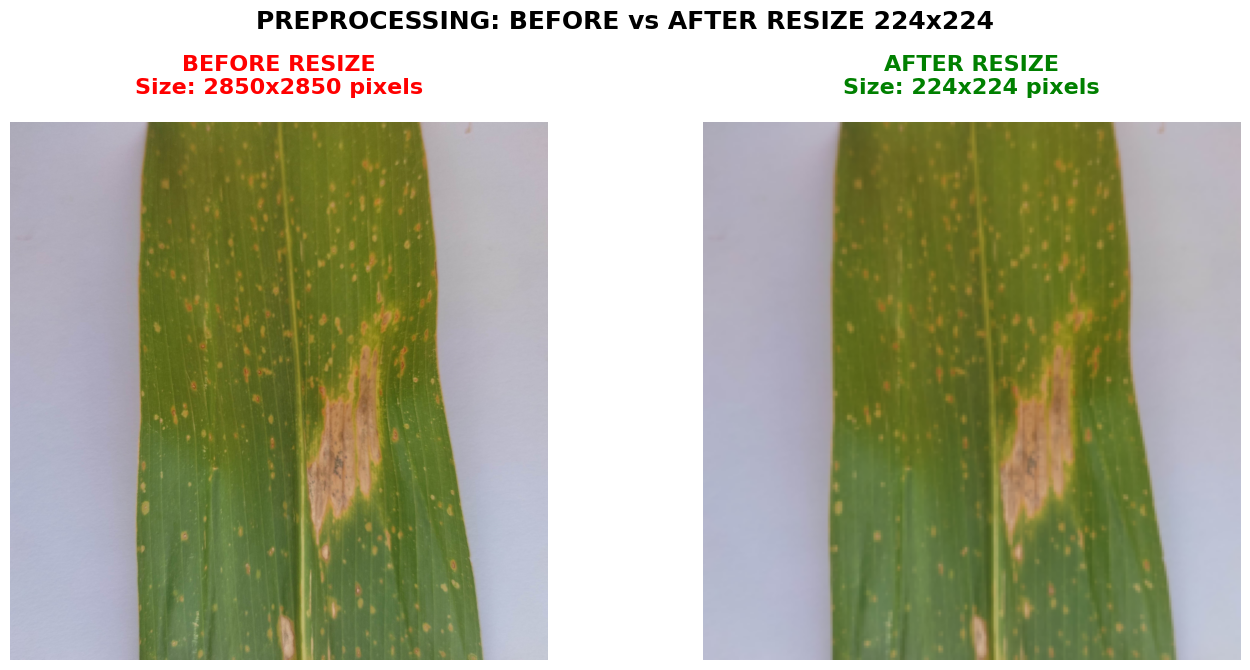


✓ Ukuran sebelum resize: 2850x2850 pixels
✓ Ukuran setelah resize: 224x224 pixels
✓ Perubahan: 2850x2850 → 224x224


In [6]:
# Visualisasi Sederhana: Before & After Resize 224x224
print("\n" + "=" * 60)
print("PERBANDINGAN SEDERHANA: BEFORE vs AFTER RESIZE 224x224")
print("=" * 60)

if sample_img_path:
    # Load gambar original
    original_img = Image.open(sample_img_path).convert('RGB')
    original_size = original_img.size
    
    # Resize ke 224x224
    resized_img = transforms.Resize((224, 224))(original_img)
    
    # Visualisasi side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # BEFORE: Original
    axes[0].imshow(original_img)
    axes[0].set_title(f'BEFORE RESIZE\nSize: {original_size[0]}x{original_size[1]} pixels', 
                     fontsize=16, fontweight='bold', color='red', pad=20)
    axes[0].axis('off')
    
    # AFTER: Resized
    axes[1].imshow(resized_img)
    axes[1].set_title('AFTER RESIZE\nSize: 224x224 pixels', 
                     fontsize=16, fontweight='bold', color='green', pad=20)
    axes[1].axis('off')
    
    plt.suptitle('PREPROCESSING: BEFORE vs AFTER RESIZE 224x224', 
                fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    
    print(f"\n✓ Ukuran sebelum resize: {original_size[0]}x{original_size[1]} pixels")
    print(f"✓ Ukuran setelah resize: 224x224 pixels")
    print(f"✓ Perubahan: {original_size[0]}x{original_size[1]} → 224x224")
    
else:
    print("✗ Tidak ada gambar sample yang ditemukan")




VISUALISASI DATA AUGMENTATION - BEFORE & AFTER


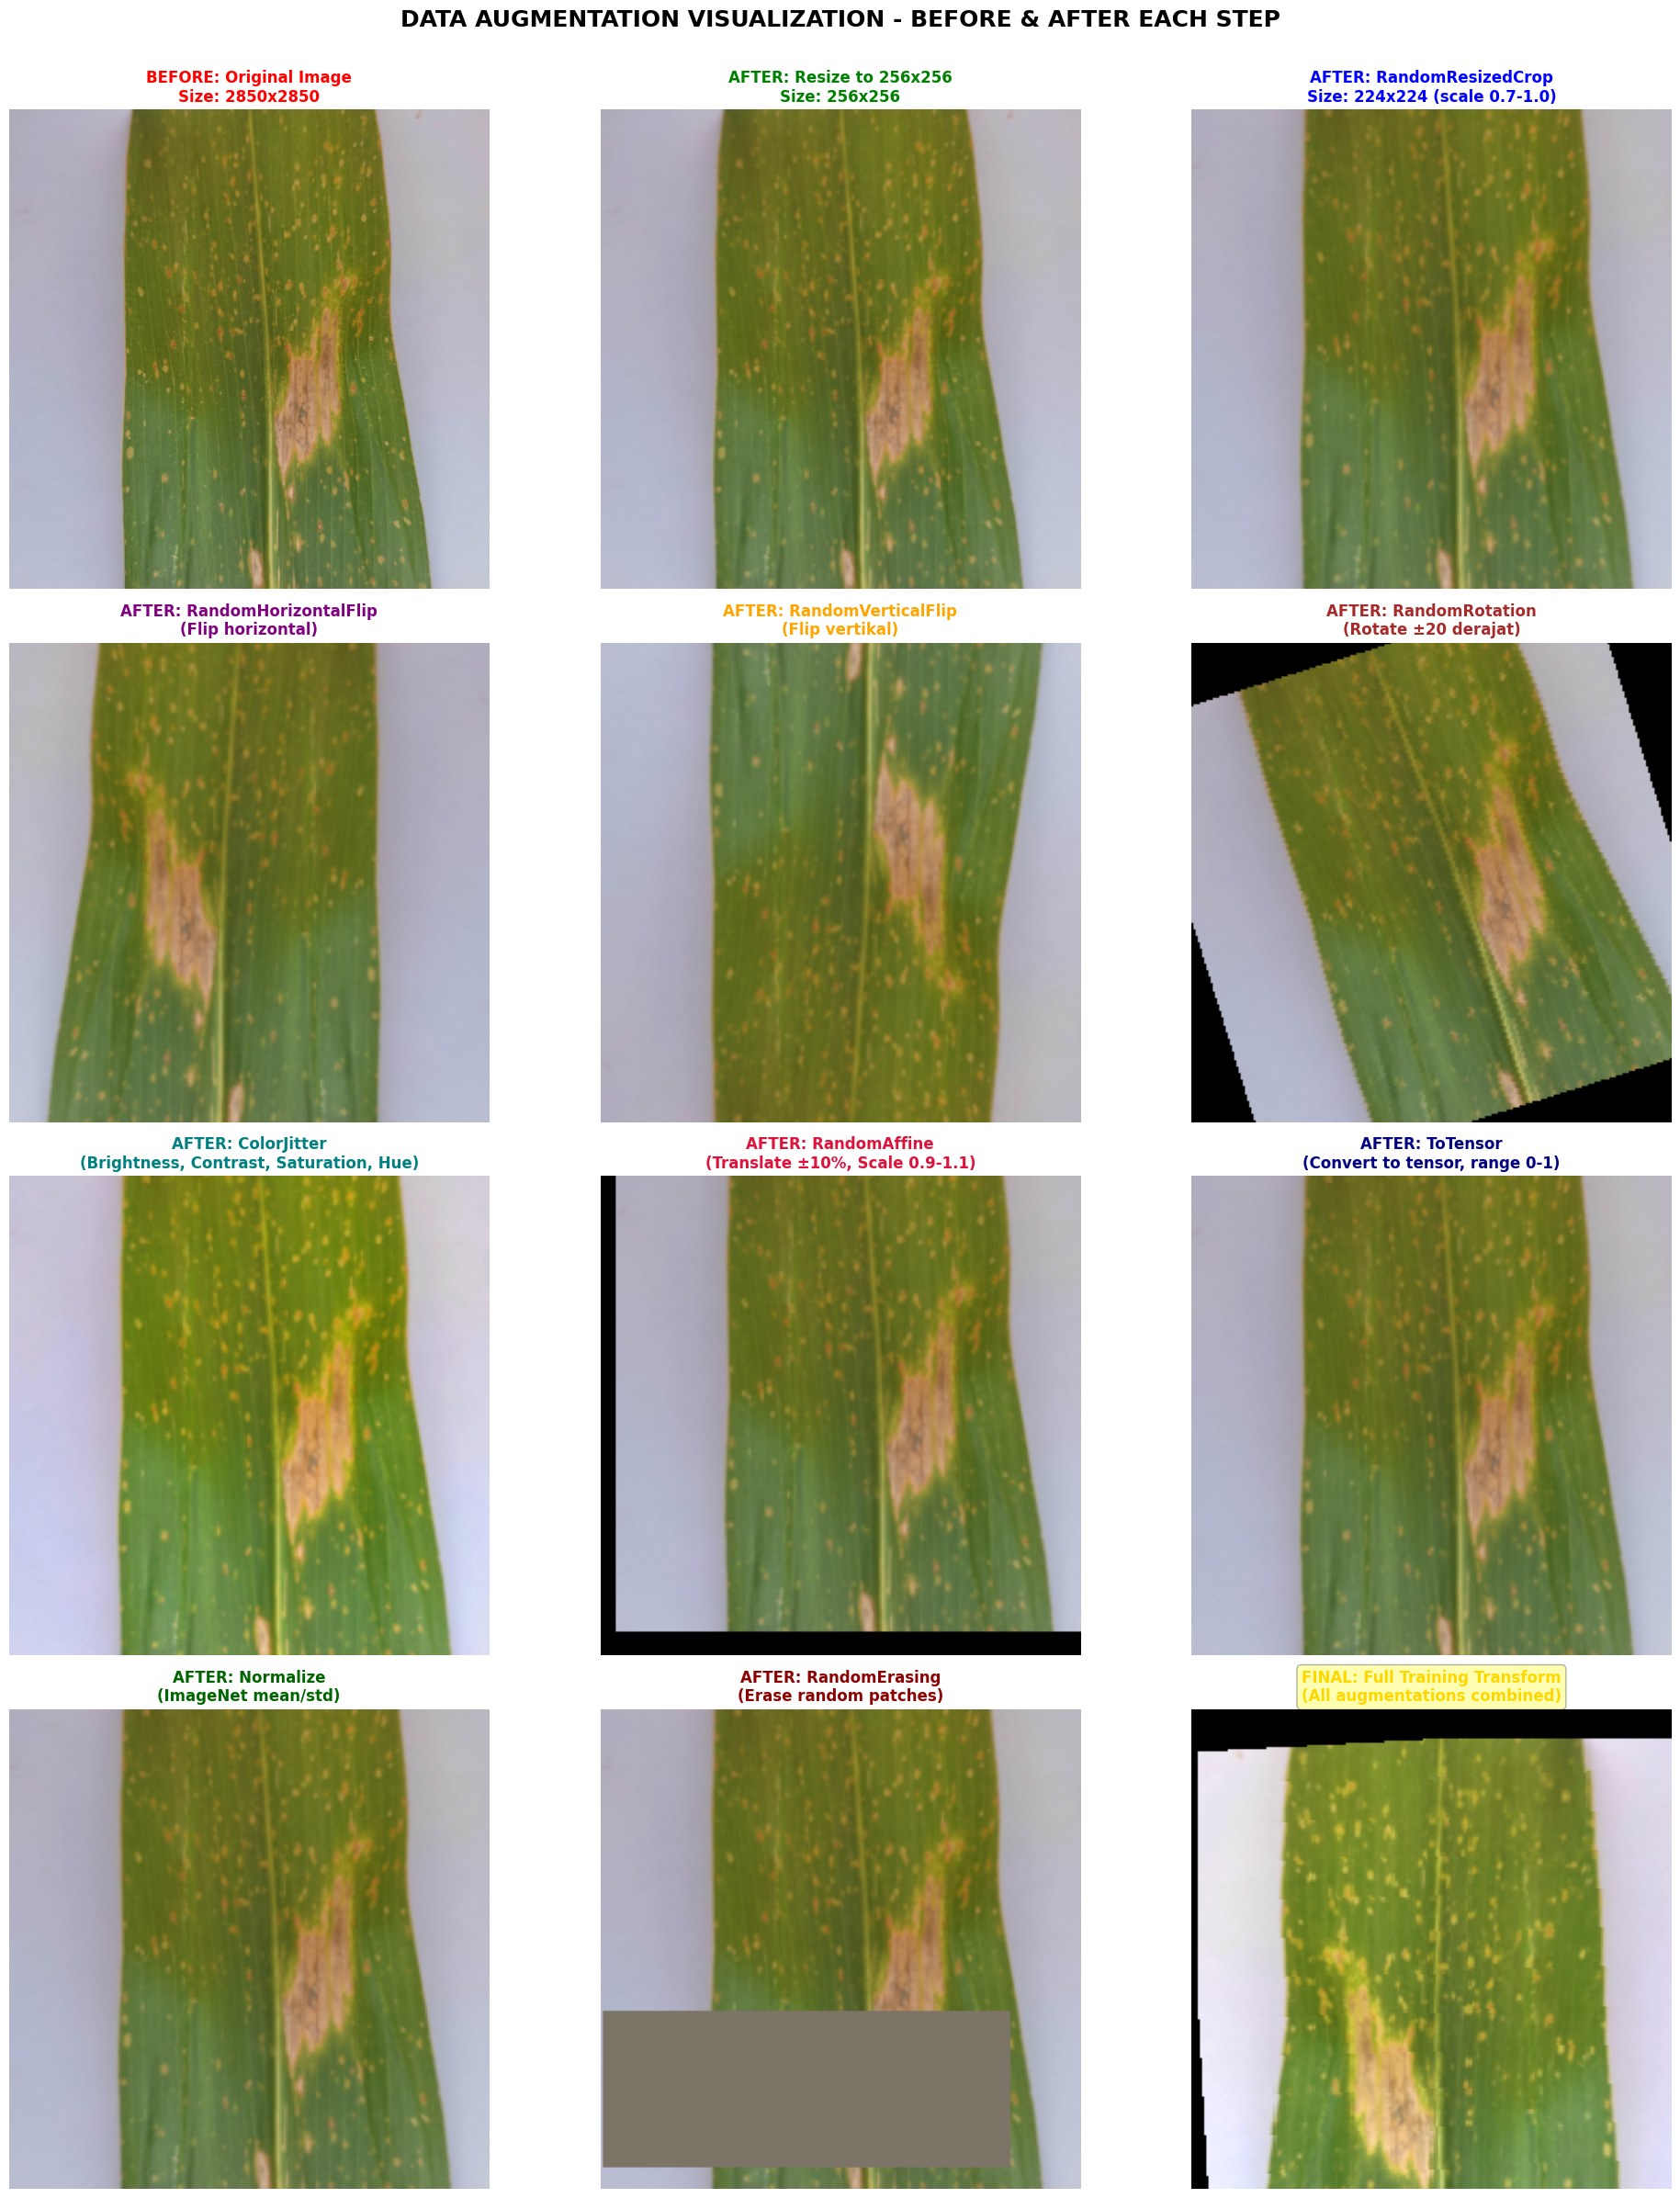


------------------------------------------------------------
RINGKASAN DATA AUGMENTATION:
------------------------------------------------------------
1. Resize to 256x256: Persiapan untuk crop
2. RandomResizedCrop 224x224: Random crop dengan scale 0.7-1.0
3. RandomHorizontalFlip: Flip horizontal (p=0.5)
4. RandomVerticalFlip: Flip vertikal (p=0.3)
5. RandomRotation: Rotasi ±20 derajat
6. ColorJitter: Variasi brightness, contrast, saturation, hue
7. RandomAffine: Translasi ±10%, scale 0.9-1.1
8. ToTensor: Konversi ke tensor (0-1)
9. Normalize: Normalisasi ImageNet mean/std
10. RandomErasing: Hapus patch random (p=0.2)
------------------------------------------------------------


In [7]:
# Visualisasi Data Augmentation - Before & After untuk Training
print("\n" + "=" * 60)
print("VISUALISASI DATA AUGMENTATION - BEFORE & AFTER")
print("=" * 60)

if sample_img_path:
    # Load gambar original
    original_img = Image.open(sample_img_path).convert('RGB')
    original_size = original_img.size
    
    # Resize dulu ke 256x256 (seperti di train_transform)
    resized_256 = transforms.Resize((256, 256))(original_img)
    
    # Visualisasi setiap langkah augmentasi
    fig = plt.figure(figsize=(20, 24))
    
    # 1. BEFORE: Original
    ax1 = plt.subplot(4, 3, 1)
    ax1.imshow(original_img)
    ax1.set_title(f'BEFORE: Original Image\nSize: {original_size[0]}x{original_size[1]}', 
                 fontsize=12, fontweight='bold', color='red')
    ax1.axis('off')
    
    # 2. AFTER: Resize to 256x256
    ax2 = plt.subplot(4, 3, 2)
    ax2.imshow(resized_256)
    ax2.set_title('AFTER: Resize to 256x256\nSize: 256x256', 
                 fontsize=12, fontweight='bold', color='green')
    ax2.axis('off')
    
    # 3. AFTER: RandomResizedCrop 224x224
    random_crop = transforms.RandomResizedCrop(224, scale=(0.7, 1.0))
    cropped_img = random_crop(resized_256)
    ax3 = plt.subplot(4, 3, 3)
    ax3.imshow(cropped_img)
    ax3.set_title('AFTER: RandomResizedCrop\nSize: 224x224 (scale 0.7-1.0)', 
                 fontsize=12, fontweight='bold', color='blue')
    ax3.axis('off')
    
    # 4. AFTER: RandomHorizontalFlip
    horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)  # p=1.0 untuk selalu flip
    flipped_h = horizontal_flip(cropped_img)
    ax4 = plt.subplot(4, 3, 4)
    ax4.imshow(flipped_h)
    ax4.set_title('AFTER: RandomHorizontalFlip\n(Flip horizontal)', 
                 fontsize=12, fontweight='bold', color='purple')
    ax4.axis('off')
    
    # 5. AFTER: RandomVerticalFlip
    vertical_flip = transforms.RandomVerticalFlip(p=1.0)  # p=1.0 untuk selalu flip
    flipped_v = vertical_flip(cropped_img)
    ax5 = plt.subplot(4, 3, 5)
    ax5.imshow(flipped_v)
    ax5.set_title('AFTER: RandomVerticalFlip\n(Flip vertikal)', 
                 fontsize=12, fontweight='bold', color='orange')
    ax5.axis('off')
    
    # 6. AFTER: RandomRotation
    rotation = transforms.RandomRotation(degrees=20)
    rotated_img = rotation(cropped_img)
    ax6 = plt.subplot(4, 3, 6)
    ax6.imshow(rotated_img)
    ax6.set_title('AFTER: RandomRotation\n(Rotate ±20 derajat)', 
                 fontsize=12, fontweight='bold', color='brown')
    ax6.axis('off')
    
    # 7. AFTER: ColorJitter
    color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
    jittered_img = color_jitter(cropped_img)
    ax7 = plt.subplot(4, 3, 7)
    ax7.imshow(jittered_img)
    ax7.set_title('AFTER: ColorJitter\n(Brightness, Contrast, Saturation, Hue)', 
                 fontsize=12, fontweight='bold', color='teal')
    ax7.axis('off')
    
    # 8. AFTER: RandomAffine
    affine = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
    affine_img = affine(cropped_img)
    ax8 = plt.subplot(4, 3, 8)
    ax8.imshow(affine_img)
    ax8.set_title('AFTER: RandomAffine\n(Translate ±10%, Scale 0.9-1.1)', 
                 fontsize=12, fontweight='bold', color='crimson')
    ax8.axis('off')
    
    # 9. AFTER: ToTensor (untuk visualisasi)
    to_tensor = transforms.ToTensor()
    tensor_img = to_tensor(cropped_img)
    ax9 = plt.subplot(4, 3, 9)
    ax9.imshow(tensor_img.permute(1, 2, 0))
    ax9.set_title('AFTER: ToTensor\n(Convert to tensor, range 0-1)', 
                 fontsize=12, fontweight='bold', color='navy')
    ax9.axis('off')
    
    # 10. AFTER: Normalize
    normalize = transforms.Normalize(mean=mean, std=std)
    normalized = normalize(tensor_img)
    normalized_vis = denormalize_tensor(normalized, mean, std)
    ax10 = plt.subplot(4, 3, 10)
    ax10.imshow(normalized_vis.permute(1, 2, 0))
    ax10.set_title('AFTER: Normalize\n(ImageNet mean/std)', 
                  fontsize=12, fontweight='bold', color='darkgreen')
    ax10.axis('off')
    
    # 11. AFTER: RandomErasing (contoh dengan probabilitas tinggi)
    # Catatan: RandomErasing bekerja pada tensor, jadi kita perlu apply setelah normalize
    random_erase = transforms.RandomErasing(p=1.0, scale=(0.02, 0.33))  # p=1.0 untuk selalu erase
    erased_tensor = random_erase(normalized.clone())
    erased_vis = denormalize_tensor(erased_tensor, mean, std)
    ax11 = plt.subplot(4, 3, 11)
    ax11.imshow(erased_vis.permute(1, 2, 0))
    ax11.set_title('AFTER: RandomErasing\n(Erase random patches)', 
                  fontsize=12, fontweight='bold', color='darkred')
    ax11.axis('off')
    
    # 12. FINAL: Full Training Transform (contoh)
    final_augmented = train_transform(original_img)
    final_vis = denormalize_tensor(final_augmented, mean, std)
    ax12 = plt.subplot(4, 3, 12)
    ax12.imshow(final_vis.permute(1, 2, 0))
    ax12.set_title('FINAL: Full Training Transform\n(All augmentations combined)', 
                  fontsize=12, fontweight='bold', color='gold', 
                  bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    ax12.axis('off')
    
    plt.suptitle('DATA AUGMENTATION VISUALIZATION - BEFORE & AFTER EACH STEP', 
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    print("\n" + "-" * 60)
    print("RINGKASAN DATA AUGMENTATION:")
    print("-" * 60)
    print("1. Resize to 256x256: Persiapan untuk crop")
    print("2. RandomResizedCrop 224x224: Random crop dengan scale 0.7-1.0")
    print("3. RandomHorizontalFlip: Flip horizontal (p=0.5)")
    print("4. RandomVerticalFlip: Flip vertikal (p=0.3)")
    print("5. RandomRotation: Rotasi ±20 derajat")
    print("6. ColorJitter: Variasi brightness, contrast, saturation, hue")
    print("7. RandomAffine: Translasi ±10%, scale 0.9-1.1")
    print("8. ToTensor: Konversi ke tensor (0-1)")
    print("9. Normalize: Normalisasi ImageNet mean/std")
    print("10. RandomErasing: Hapus patch random (p=0.2)")
    print("-" * 60)
    
else:
    print("✗ Tidak ada gambar sample yang ditemukan untuk visualisasi")

